# HW4 - Text Classification

Student Name: Chunran Yao, Ze Chen

Data comes from:
https://www.kaggle.com/areeves87/rscience-popular-comment-removal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, roc_auc_score
from scipy.sparse import coo_matrix, hstack
from gensim import models
import re
import gensim.parsing.preprocessing as preprocessing
import spacy

# import data

In [2]:
train = pd.read_csv("reddit_200k_train.csv", encoding = 'latin1', index_col = 'Unnamed: 0') 
test = pd.read_csv("reddit_200k_test.csv",encoding='latin1', index_col = 'Unnamed: 0')

In [3]:
train.head()

,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False
2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [4]:
test.head()

,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
1,"Hi Larpo_Nadar, your submission has been remov...",0,t3_74udg6,do15nly,1507377013,1509603985,True
2,"So out of every 10,000 children with autism wh...",8,t3_879uw5,dwc3dps,1522107010,1525623538,False
3,"When I was pregnant, I was warned against eati...",4,t3_5qo49s,dd1wtw2,1485686073,1486529379,False
4,Imagine if this find was the bug that eradicat...,14,t3_5qmr9c,dd0qpcr,1485618726,1486509114,True
5,Is it a myth that the math says it would take ...,0,t3_6wtiwg,dmb0sg4,1504050679,1504495504,False


In [5]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1:]

# Data Exploration

Since the train and test dataset have already been split, I won't combine them and will just use train data in data exploration.

## Analyze the features

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167529 entries, 1 to 167529
Data columns (total 6 columns):
body             167529 non-null object
score.x          167529 non-null int64
parent_id.x      167529 non-null object
id               167529 non-null object
created_utc.x    167529 non-null int64
retrieved_on     167529 non-null int64
dtypes: int64(3), object(3)
memory usage: 8.9+ MB


This dataset has 6 features:     

1. **body:**       
text data, object

2. **score.x**:       

comment score, int 

In [7]:
len(np.unique(X_train.iloc[:,1]))

2183

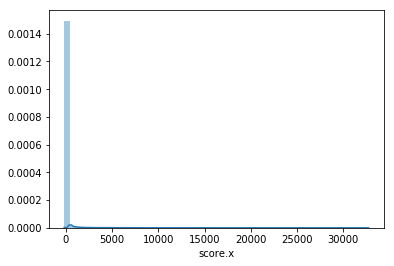

In [8]:
sns.distplot(X_train.iloc[:,1])

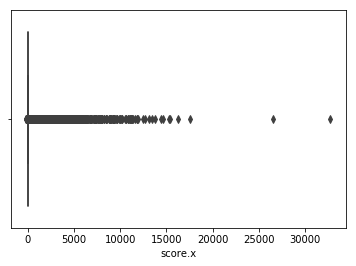

In [9]:
sns.boxplot(X_train.iloc[:,1])

It has 2183 unique values.  
Most of the values are around 0, but there are some values which are more than 5000, even more than 20000.     
Are they outliers? Drop them or discretize.

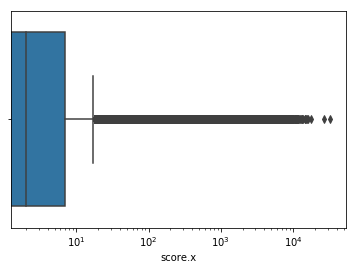

In [10]:
sns.boxplot(X_train.iloc[:,1])
plt.xscale('log')

Applying log transform on score.x can make it better.

3. **parent_id.x**     

the id of the parent post，object

In [11]:
np.unique(X_train.iloc[:,2])

array(['t3_5a17i1', 't3_5ivw50', 't3_5k1jdv', ..., 't3_9ka45a',
       't3_9kaa5e', 't3_9kaok5'], dtype=object)

In [12]:
len(np.unique(X_train.iloc[:,2]))

18487

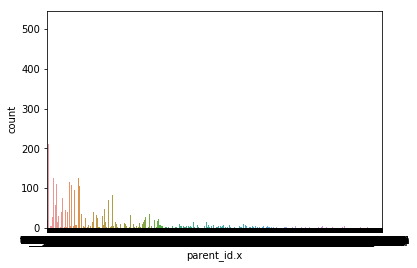

In [13]:
sns.countplot(X_train.iloc[:,2].astype(str))

It has 18487 unique values. Some values appears more, such as more than 50 times, while others may appear less. Thus we use targetencoder.

4. **id**:

In [14]:
len(np.unique(X_train.iloc[:,3]))

167529

It is the id of the post. The values of this feature are all unique.

5. **created_utc.x**:      

In [15]:
len(np.unique(X_train.iloc[:,4]))

166992

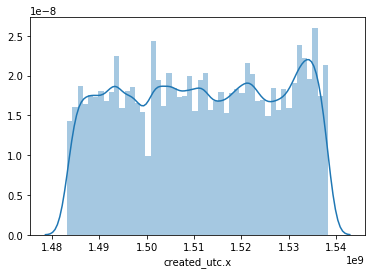

In [16]:
sns.distplot(X_train.iloc[:,4])

a POSIX timestamp, int.         
This feature is timestamp, so it need special processing later.     
The unique value of this feature is too many. And the distribution of this feature is similar to uniform distribution.

6. **retrieved_on**:     

In [17]:
len(np.unique(X_train.iloc[:,5]))

165955

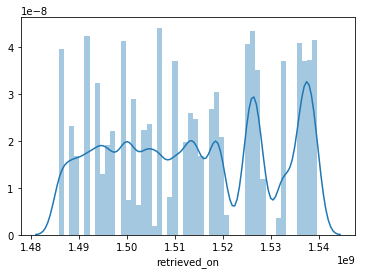

In [18]:
sns.distplot(X_train.iloc[:,5])

int     
The unique value of this feature is too many.

### Missing data

There is no missing data.

## Analyze the target

In [9]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167529 entries, 1 to 167529
Data columns (total 1 columns):
REMOVED    167529 non-null bool
dtypes: bool(1)
memory usage: 1.4 MB


In [10]:
np.unique(y_train.values)

array([False,  True])

The value of y is bool (either True or False).          
It means the post is removed (True) or not (False).

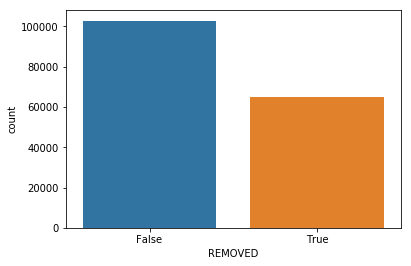

In [21]:
sns.countplot(y_train.iloc[:,0])

So it is imbalanced data, more False than True.

## Dependency plot

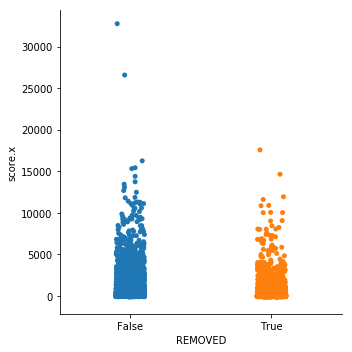

In [10]:
sns.catplot(y = "score.x", x = "REMOVED", data = train)

From this plot, it seems that post with higher score.x are more likely to be removed.

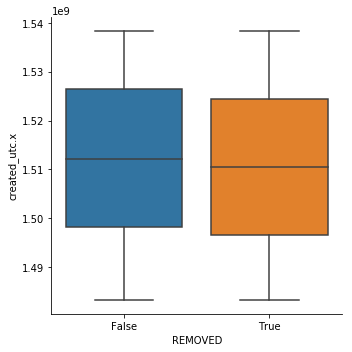

In [11]:
sns.catplot(y = "created_utc.x", x = "REMOVED",data = train, kind = 'box')

From this plot, it seems that post with higher created_utc.x are more likely to be removed.

For other features: body, parent_id, id, retrieved_on, it is hard to plot the relationship between feature and target because of datatype or too many unique values.

# Data Preprocessing and feature selection

## Data Preprocessing

### deal with time data

In [6]:
year = []
month =[]
day = []
hour = []
minute = []
second = []
for i in range(0,X_train.shape[0]):
    parsed_date = datetime.utcfromtimestamp(X_train.iloc[i,4])
    year.append(parsed_date.year)
    month.append(parsed_date.month)
    day.append(parsed_date.day)
    hour.append(parsed_date.hour)
    minute.append(parsed_date.minute)
    second.append(parsed_date.second)   

In [7]:
X_train['year'] = year
X_train['month'] = month
X_train['day'] = day
X_train['hour'] = hour
X_train['minute'] = minute
X_train['second'] = second

In [8]:
X_train = X_train.drop(['created_utc.x'],axis = 1)

Same transform on test data:

In [9]:
year = []
month =[]
day = []
hour = []
minute = []
second = []
for i in range(0,X_test.shape[0]):
    parsed_date = datetime.utcfromtimestamp(X_test.iloc[i,4])
    year.append(parsed_date.year)
    month.append(parsed_date.month)
    day.append(parsed_date.day)
    hour.append(parsed_date.hour)
    minute.append(parsed_date.minute)
    second.append(parsed_date.second)  
X_test['year'] = year
X_test['month'] = month
X_test['day'] = day
X_test['hour'] = hour
X_test['minute'] = minute
X_test['second'] = second
X_test = X_test.drop(['created_utc.x'],axis = 1)

In [10]:
X_train.loc[:,'year'] = X_train.loc[:,'year'].astype(object)
X_test.loc[:,'year'] = X_test.loc[:,'year'].astype(object)

I change the data type of year, but not other time features. I am not sure should they be treated as catogorical or continuous. So i will just keep them continuous for now. 
https://stats.stackexchange.com/questions/164542/is-time-of-the-day-predictor-in-regression-a-categorical-or-a-continuous-varia/164568

Distribution plot of time feature after preprocessing:

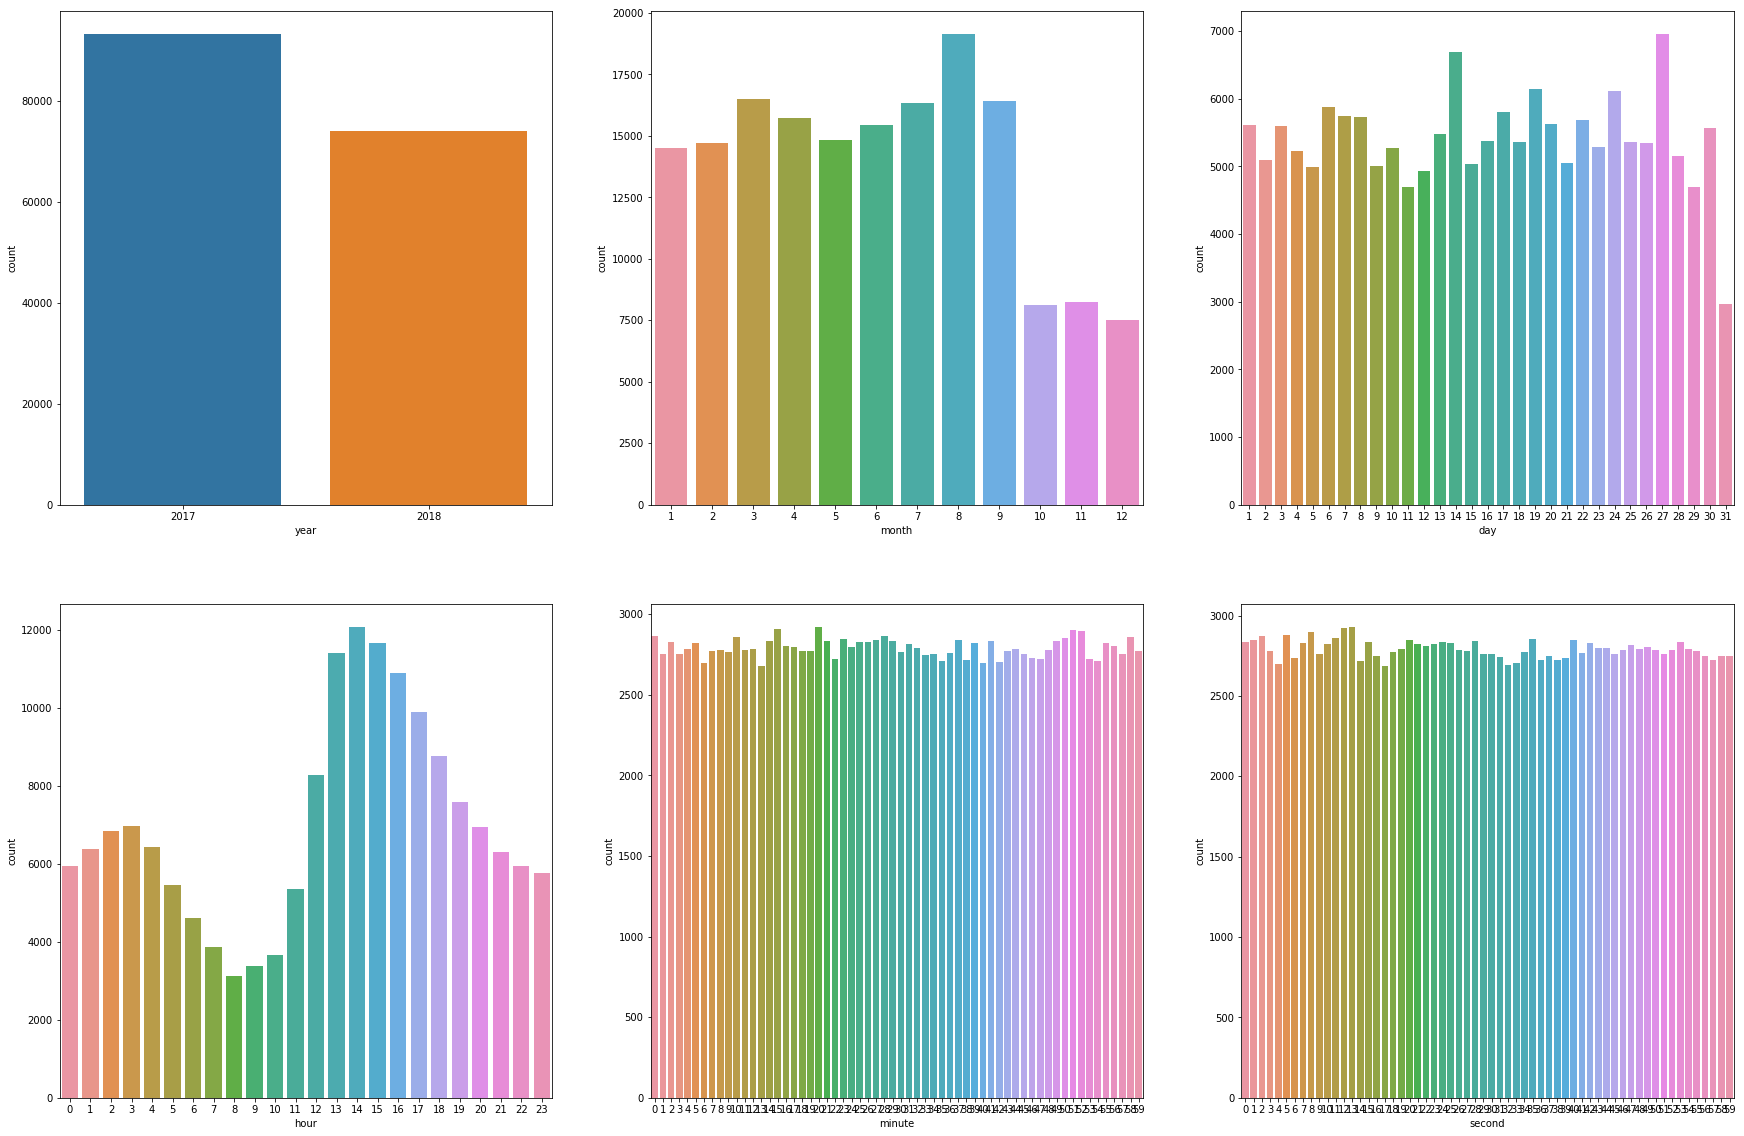

In [11]:
fig, axes = plt.subplots(2,3,figsize = (30,20))
sns.countplot(X_train.loc[:,'year'], ax=axes[0,0])
sns.countplot(X_train.loc[:,'month'], ax=axes[0,1])
sns.countplot(X_train.loc[:,'day'], ax=axes[0,2])
sns.countplot(X_train.loc[:,'hour'], ax=axes[1,0])
sns.countplot(X_train.loc[:,'minute'], ax=axes[1,1])
sns.countplot(X_train.loc[:,'second'], ax=axes[1,2])

Dependency plot of preprocessed features:

In [11]:
train = pd.concat([X_train,y_train], axis=1)

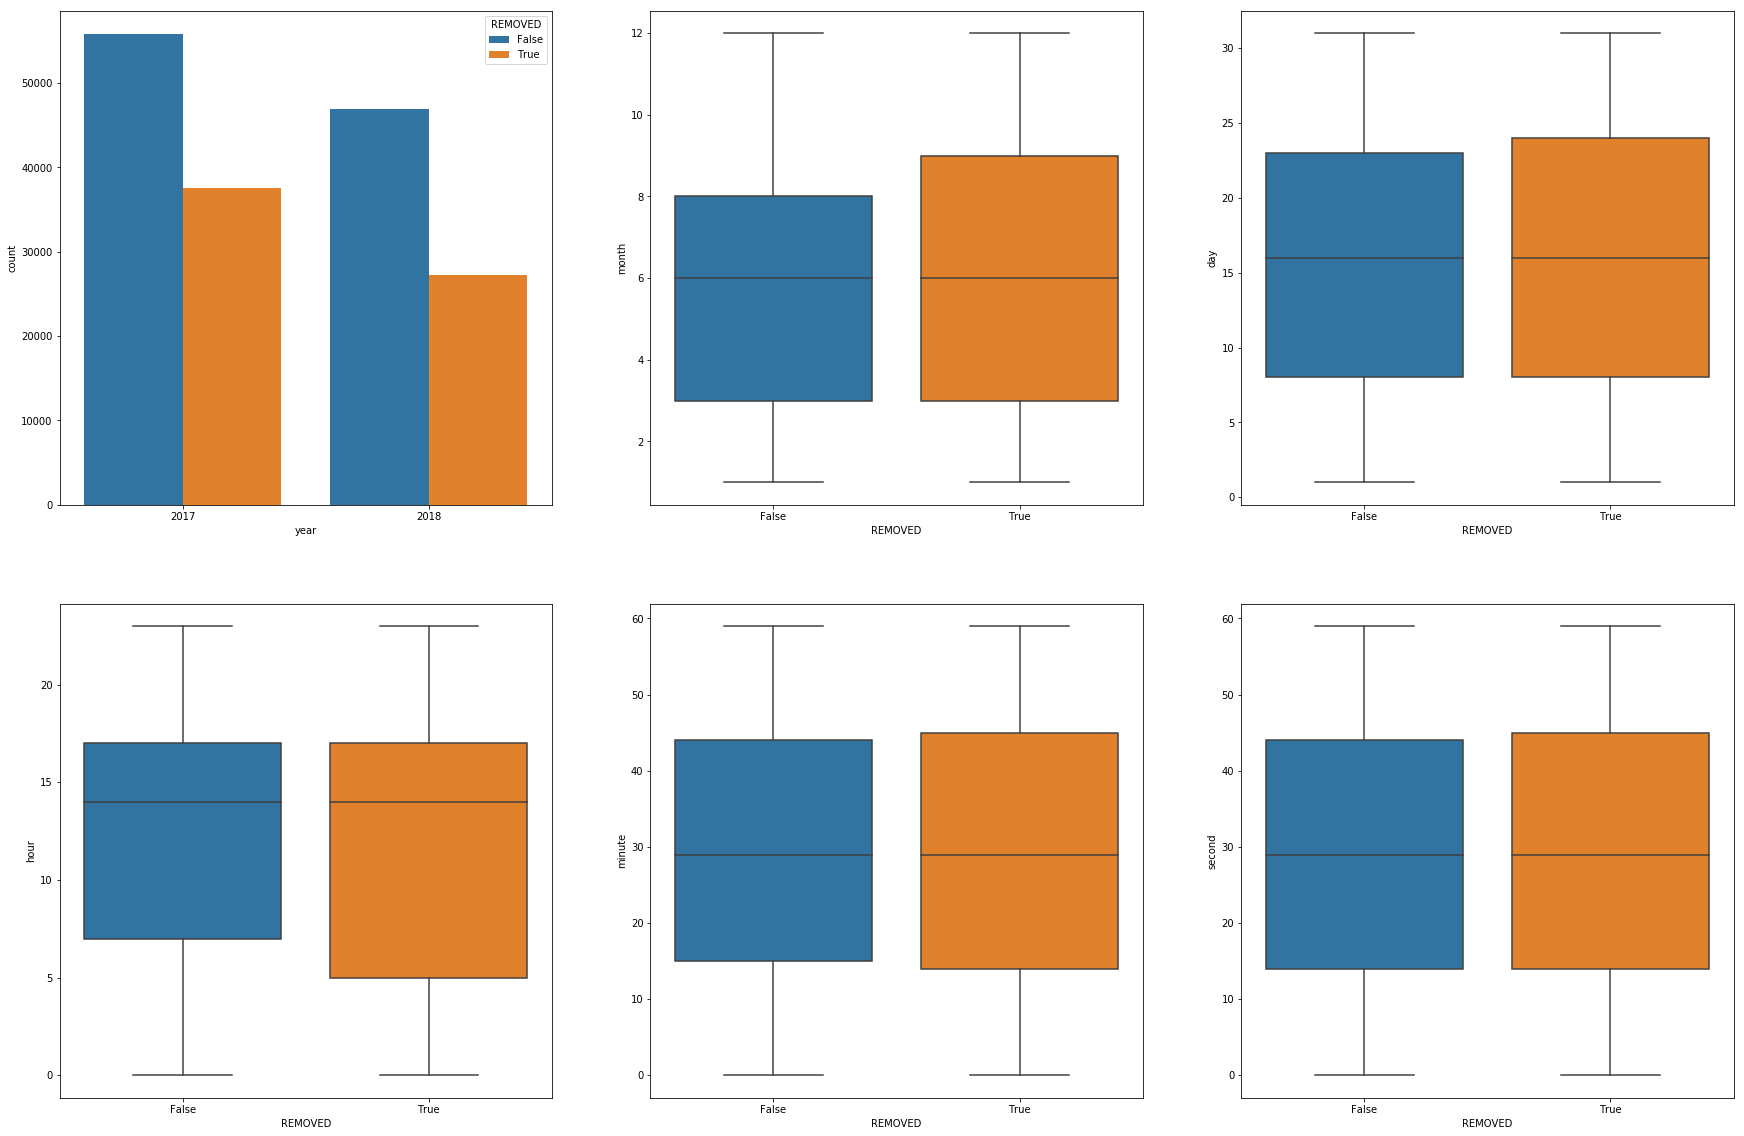

In [12]:
fig, axes = plt.subplots(2,3,figsize = (30,20))
sns.countplot(x = 'year' , hue = 'REMOVED', data = train, ax=axes[0,0])
sns.boxplot(y = 'month' , x = 'REMOVED', data = train, ax=axes[0,1])
sns.boxplot(y = 'day' , x = 'REMOVED', data = train, ax=axes[0,2])
sns.boxplot(y = 'hour' , x = 'REMOVED', data = train, ax=axes[1,0])
sns.boxplot(y = 'minute' , x = 'REMOVED', data = train, ax=axes[1,1])
sns.boxplot(y = 'second' , x = 'REMOVED', data = train, ax=axes[1,2])

It seems that **month** and **hour** may associate with target.

### discretization

**score.x:**     
According to data exploration, we can discretize score.x into log interval.    
The corresponding is:   
- 1 - -100~-10
- 2 - -10~0
- 3 - 0~10
- 4 - 10~100
- 5 - 100~1000
- 6 - 1000~10000
- 7 - 10000~100000

In [13]:
bins = sorted(list(-np.power(10,range(1,3))))
bins.append(0)
bins = bins + list(np.power(10,range(1,6)))

In [14]:
score_x = np.digitize(X_train.loc[:,'score.x'],bins)
X_train['score.x_discrete'] = score_x
X_train.loc[:,'score.x_discrete'] = X_train.loc[:,'score.x_discrete'].astype(object)  #change the data type

In [15]:
score_x = np.digitize(X_test.loc[:,'score.x'],bins)
X_test['score.x_discrete'] = score_x
X_test.loc[:,'score.x_discrete'] = X_test.loc[:,'score.x_discrete'].astype(object)

drop score.x (original feature):

In [16]:
X_train = X_train.drop(['score.x'], axis = 1)
X_test = X_test.drop(['score.x'], axis = 1)

## feature selection

Since the values in **id** are all unique, it won't contribute to the prediction.

In [17]:
X_train = X_train.drop(['id'],axis = 1)
X_test = X_test.drop(['id'],axis = 1)

### Covariance:

In [18]:
X_train_scaled = scale(OrdinalEncoder().fit_transform(X_train))
cov = np.cov(X_train_scaled, rowvar=False)

In [19]:
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype="int")

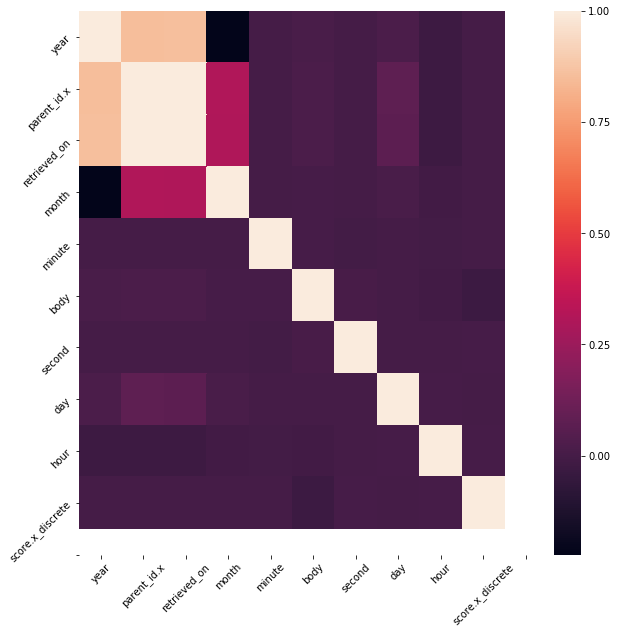

In [20]:
plt.figure(figsize = (10, 10))
sns.heatmap(cov[:,order][order])
_ = plt.xticks(ticks=np.arange(0.5,11.5,1),labels=X_train.iloc[:,order].columns, rotation = 45)
_ = plt.yticks(ticks=np.arange(0.5,11.5,1),labels=X_train.iloc[:,order].columns, rotation = 45)

Covariance matrix indicates that **parent_id.x** and **retrieved_on** are highly associated with each other, and they are also associated with **month**. In order to remove highly correlated features, I consider choose one from **parent_id.x** and **retrieved_on**.

### Univariate Statistics

**chi2**

In [21]:
chi_2, p_values = chi2(OrdinalEncoder().fit_transform(X_train), y_train)

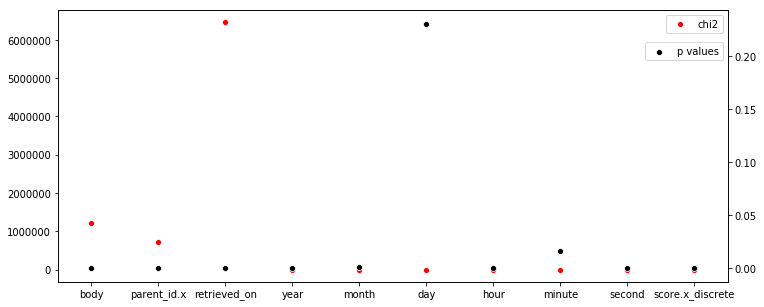

In [22]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot()
sns.scatterplot(y = chi_2, x = X_train.columns, ax=ax1, color = 'red')
ax1.legend(labels = ['chi2'], loc = 1)
ax2 = ax1.twinx()
sns.scatterplot(y = p_values, x = X_train.columns, ax=ax2, color = 'black')
ax2.legend(labels = ['p values'], bbox_to_anchor=(1, 0.9))

Chi2 indicates that **day** and **minute** is unrealted with target; and **retrieved_on** is more associated with target than other features. In fact, the chi2 value of **retrieved_on** is extremely high.

**Mutual information**

In [23]:
mi = mutual_info_classif(OrdinalEncoder().fit_transform(X_train), y_train, discrete_features=[0,1,3,4,5,6,7,8,9])

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
mi

array([6.66213582e-01, 1.97388939e-01, 1.11088895e-01, 6.46232150e-04,
       2.42600669e-03, 2.29854771e-03, 2.10475882e-03, 1.68018351e-04,
       1.87116307e-04, 7.45477548e-03])

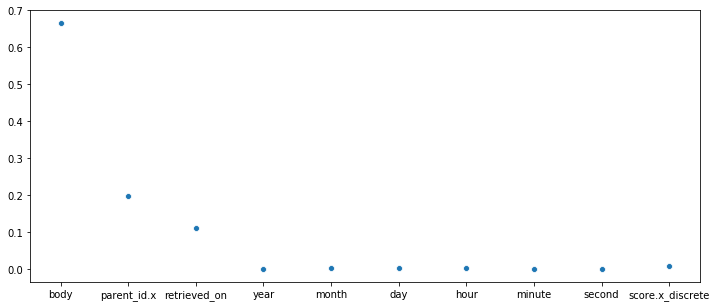

In [25]:
plt.figure(figsize=(12,5))
sns.scatterplot(y = mi, x = X_train.columns)

Based on all the data exploration and analyze, I choose **body**, **parent_id.x**, **score.x_discrete**, **month**, **hour** in my first model.

In [26]:
X_train_original = X_train.copy()

In [27]:
X_train = X_train.loc[:,['body','parent_id.x','score.x_discrete','month','hour']]

# Feature Engineer & Models

## Baseline Model : just predict the majority class (y = False)

In [28]:
y_pred = [False]*y_test.shape[0]

Since the data is from Kaggle and the corresponding kernels are suing roc_auc as metric, I will also use this metric.

In [29]:
baseline_auc = roc_auc_score(y_test,y_pred)
baseline_auc

0.5

In [30]:
confusion_matrix(y_test,y_pred)

array([[34565,     0],
       [21278,     0]])

## Model1: Bag of words and Naive Bayes

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167529 entries, 1 to 167529
Data columns (total 5 columns):
body                167529 non-null object
parent_id.x         167529 non-null object
score.x_discrete    167529 non-null object
month               167529 non-null int64
hour                167529 non-null int64
dtypes: int64(2), object(3)
memory usage: 12.7+ MB


In [88]:
continuous_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'median')),('scaler', Normalizer())])
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'constant', fill_value = 'missing')),('scaler', OneHotEncoder(handle_unknown = 'ignore'))])
text_transformer = Pipeline(steps = [('vectorizer', TfidfVectorizer(ngram_range = (2,3), min_df = 1))])


In [89]:
preprocess = make_column_transformer((text_transformer,'body'),(categorical_transformer,['parent_id.x','score.x_discrete', 'month','hour']))


When using the TfidfVectorizer, it will return sparse matrix, but some estimators only accept dense data, for example, GaussianNB.     
One way is using toarray to change the type of data. To put it into pipeline, use FunctionTransformer to change it to dense. But too much features will make kernel to die on my computer. So set min_df = 5.
I use MultinomialNB since it's more suitable for textdata (wordcount). MultinomialNB requires non-negative, for convenience I just set all features to categorical. MultinomialNB accepts sparse input.
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

I don't use scaler after tf-idf since naive bayes doesn't need scale in theory.

In [90]:
baseline_nb = make_pipeline(preprocess,
                            #FunctionTransformer(lambda x: x.toarray(), accept_sparse=True), 
                            MultinomialNB())

In [91]:
param_grid = {"multinomialnb__alpha": [0,1.0,2.0],
             "columntransformer__pipeline-1__vectorizer__analyzer": ['char_wb','word']}
grid_baseline_nb = GridSearchCV(baseline_nb,
                             param_grid=param_grid, cv=5, scoring="roc_auc" )

In [92]:
grid_baseline_nb.fit(X_train,y_train)

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        ...'month', 'hour'])])), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'multinomialnb__alpha': [0, 1.0, 2.0], 'columntransformer__pipeline-1__vectorizer__analyzer': ['char_wb', 'word']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [93]:
grid_baseline_nb.best_params_

{'columntransformer__pipeline-1__vectorizer__analyzer': 'char_wb',
 'multinomialnb__alpha': 1.0}

In [94]:
grid_baseline_nb.best_score_

0.8487513902376475

In [95]:
grid_baseline_nb.cv_results_['mean_test_score']

array([0.83063825, 0.84875139, 0.84426412, 0.75277804, 0.83071662,
       0.82390552])

In [96]:
grid_baseline_nb.best_estimator_.score(X_test,y_test)

0.7794531096108733

**feature importance:**

In [97]:
coef = grid_baseline_nb.best_estimator_.named_steps['multinomialnb'].coef_.flatten()

In [98]:
text_names = grid_baseline_nb.best_estimator_.named_steps['columntransformer'].named_transformers_['pipeline-1'].named_steps['vectorizer'].get_feature_names()
onehot_names = grid_baseline_nb.best_estimator_.named_steps['columntransformer'].named_transformers_['pipeline-2'].named_steps['scaler'].get_feature_names()
column_names = list(text_names) + list(onehot_names)

In [99]:
coef

array([-13.88247418, -13.88247418, -13.88247418, ...,  -6.11351814,
        -6.09675329,  -6.1021711 ])

In [100]:
coef_nb = pd.Series(coef)
coef_nb.index = column_names

In [131]:
coef_nb.nsmallest(50)

     -13.882474
     -13.882474
     -13.882474
 !)   -13.882474
 !,   -13.882474
 !d   -13.882474
 !â   -13.882474
 "&   -13.882474
 "'   -13.882474
 "+   -13.882474
 ",   -13.882474
 "~   -13.882474
 "á   -13.882474
 "â   -13.882474
 "ã   -13.882474
 #!   -13.882474
 #'   -13.882474
 #5   -13.882474
 #9   -13.882474
 #:   -13.882474
 #[   -13.882474
 #j   -13.882474
 #k   -13.882474
 #q   -13.882474
 #â   -13.882474
 $!   -13.882474
 $)   -13.882474
 $,   -13.882474
 $-   -13.882474
 $\   -13.882474
 $a   -13.882474
 $h   -13.882474
 $o   -13.882474
 $u   -13.882474
 $y   -13.882474
 ${   -13.882474
 %!   -13.882474
 %'   -13.882474
 %)   -13.882474
 %,   -13.882474
 %0   -13.882474
 %5   -13.882474
 %9   -13.882474
 %?   -13.882474
 %@   -13.882474
 %a   -13.882474
 %b   -13.882474
 %c   -13.882474
 %e   -13.882474
 %f   -13.882474
dtype: float64

All the coefficients are negative, so I just pick up smallest. Since ngram is too small, there is few words that can be interpreted. Most of the features contains special words. Therefore, I considering adding features that indicates whether there is special words.

## Feature Engineering

Feature engineering focuses on adding more features, includes length of comments and special characters.

In [132]:
X_train['quotation'] = X_train.loc[:,'body'].str.count('\'|\"')
X_train['html'] = X_train.loc[:,'body'].str.count('http:|html')
X_train['dirtywords'] = X_train.loc[:,'body'].str.count('fuck|shit|damn|bitches')
X_train['@'] = X_train.loc[:,'body'].str.count('@') 
X_train['!'] = X_train.loc[:,'body'].str.count('!') 
X_train['#'] = X_train.loc[:,'body'].str.count('#') 
X_train['&'] = X_train.loc[:,'body'].str.count('&') 
X_train['+'] = X_train.loc[:,'body'].str.count('\+') 
X_train['~'] = X_train.loc[:,'body'].str.count('~')
X_train['bracket'] = X_train.loc[:,'body'].str.count('\(|\)') 
X_train[':'] = X_train.loc[:,'body'].str.count(':')
X_train['$'] = X_train.loc[:,'body'].str.count('$')
X_train['%'] = X_train.loc[:,'body'].str.count('%')
X_train['number'] = X_train.loc[:,'body'].str.count('[0-9]') 
X_train['length'] = X_train.loc[:,'body'].str.len()

In [133]:
X_test['quotation'] = X_test.loc[:,'body'].str.count('\'|\"')
X_test['html'] = X_test.loc[:,'body'].str.count('http:|html')
X_test['dirtywords'] = X_test.loc[:,'body'].str.count('fuck|shit|damn|bitches')
X_test['@'] = X_test.loc[:,'body'].str.count('@') 
X_test['!'] = X_test.loc[:,'body'].str.count('!') 
X_test['#'] = X_test.loc[:,'body'].str.count('#') 
X_test['&'] = X_test.loc[:,'body'].str.count('&') 
X_test['+'] = X_test.loc[:,'body'].str.count('\+') 
X_test['~'] = X_test.loc[:,'body'].str.count('~')
X_test['bracket'] = X_test.loc[:,'body'].str.count('\(|\)') 
X_test[':'] = X_test.loc[:,'body'].str.count(':')
X_test['$'] = X_test.loc[:,'body'].str.count('$')
X_test['%'] = X_test.loc[:,'body'].str.count('%')
X_test['number'] = X_test.loc[:,'body'].str.count('[0-9]') 
X_test['length'] = X_test.loc[:,'body'].str.len()

In [134]:
X_train.head()

,body,parent_id.x,score.x_discrete,month,hour,quotation,html,dirtywords,@,!,:,$,length,#,&,+,~,bracket,number,%
1,I've always been taught it emerged from the ea...,t3_81u15i,3,3,23,1,0,0,0,0,0,1,125,0,0,0,0,0,0,0
2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",t3_72sk35,3,9,17,5,0,0,0,0,0,1,229,0,0,0,0,0,0,0
3,Monday: Drug companies stock dives on good new...,t3_8o88yr,3,6,4,0,0,0,0,0,1,1,61,0,0,0,0,0,0,0
4,i learned that all hybrids are unfertile i won...,t3_6xg9t8,3,9,18,0,0,0,0,0,1,1,139,0,0,0,0,0,5,0
5,Well i was wanting to get wasted tonight. Not...,t3_99wi9m,3,8,19,0,0,0,0,0,0,1,84,0,0,0,0,0,0,0


In [135]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167529 entries, 1 to 167529
Data columns (total 20 columns):
body                167529 non-null object
parent_id.x         167529 non-null object
score.x_discrete    167529 non-null object
month               167529 non-null int64
hour                167529 non-null int64
quotation           167529 non-null int64
html                167529 non-null int64
dirtywords          167529 non-null int64
@                   167529 non-null int64
!                   167529 non-null int64
:                   167529 non-null int64
$                   167529 non-null int64
length              167529 non-null int64
#                   167529 non-null int64
&                   167529 non-null int64
+                   167529 non-null int64
~                   167529 non-null int64
bracket             167529 non-null int64
number              167529 non-null int64
%                   167529 non-null int64
dtypes: int64(17), object(3)
memory usage: 31.

In [136]:
continuous_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'median')),('scaler', Normalizer())])
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'constant', fill_value = 'missing')),('scaler', OneHotEncoder(handle_unknown = 'ignore'))])
text_transformer = Pipeline(steps = [('vectorizer', TfidfVectorizer(analyzer = 'char_wb', ngram_range = (2,3), min_df = 1))])


In [137]:
preprocess = make_column_transformer((text_transformer,'body'),(categorical_transformer,['parent_id.x','score.x_discrete', 'month','hour']),(continuous_transformer,['quotation','html','dirtywords','@','!',':','$','#','&','+','~','%','bracket','number','length']))


In [138]:
baseline_nb_fe = make_pipeline(preprocess,
                            MultinomialNB())

In [139]:
score = cross_val_score(baseline_nb_fe,X=X_train, y=y_train, cv=5, scoring="roc_auc")

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [140]:
score

array([0.84672788, 0.8471475 , 0.84789227, 0.848157  , 0.85294855])

In [141]:
baseline_nb_fe.fit(X_train, y_train)
baseline_nb_fe.score(X_test,y_test)

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.778736815715488

## Model 2: Bag of Words and Gradient Boosting

TO DO

## Task 2 Word Vector

In [92]:
for i in range(0,len(text_train_lst)):
    text_train_lst[i] = preprocessing.remove_stopwords(text_train_lst[i])
    text_train_lst[i] = preprocessing.strip_punctuation(text_train_lst[i])

In [93]:
texts = [[token for token in re.split('\W+',doc)] for doc in text_train_lst]

**Word2vec pre-trained**

In [89]:
#use the GoogleNew dictionary
w = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [94]:
#deal with the words not in w
for i in range(0, len(texts)):
    for j in range(0,len(texts[i])):
        if texts[i][j] not in w.vocab:
            texts[i][j] = 'unknown'

In [95]:
 X_train = np.vstack([np.mean(w[doc], axis=0) for doc in texts])

In [104]:
param_grid = {"C": [10, 1, 0.1, 0.01, 0.001]}
grid_w2v = GridSearchCV(LogisticRegression(),param_grid=param_grid, cv=5, scoring="f1_macro")

In [105]:
grid_w2v.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [106]:
grid_w2v.best_params_

{'C': 10}

In [107]:
grid_w2v.best_score_

0.6397384179079968

**Fasttext pre-trained crawl**

In [171]:
#use the crawl-300d-2M dictionary, fasetext pre-trained
#https://github.com/RaRe-Technologies/gensim/issues/814
w2 = models.KeyedVectors.load_word2vec_format('crawl-300d-2M.vec', binary=False)

In [182]:
texts = [[token for token in re.split('\W+',doc)] for doc in text_train_lst]

In [184]:
#deal with the words not in w2
for i in range(0, len(texts)):
    for j in range(0,len(texts[i])):
        if texts[i][j] not in w2.vocab:
            texts[i][j] = 'unknown'

In [185]:
 X_train = np.vstack([np.mean(w2[doc], axis=0) for doc in texts])

In [186]:
grid_w2v.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [187]:
grid_w2v.best_params_

{'C': 10}

In [188]:
grid_w2v.best_score_

0.6568765489096293

**Fasttext pre-trained wiki-news with subword**

In [189]:
#use the wikipedia dictionary, fasetext pre-trained
w3 = models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M-subword.vec', binary=False)

In [190]:
texts = [[token for token in re.split('\W+',doc)] for doc in text_train_lst]

In [191]:
#deal with the words not in w2
for i in range(0, len(texts)):
    for j in range(0,len(texts[i])):
        if texts[i][j] not in w3.vocab:
            texts[i][j] = 'unknown'

In [192]:
 X_train = np.vstack([np.mean(w3[doc], axis=0) for doc in texts])

In [193]:
grid_w2v.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [194]:
grid_w2v.best_params_

{'C': 10}

In [195]:
grid_w2v.best_score_

0.6374199796830509

Comments

They tend to not have significant improvement for classification.